In [ ]:
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.10.0
    Uninstalling keras-3.10.0:
      Successfully uninstalled keras-3.10.0


In [ ]:
!pip install tensorflow

## **Getting Dataset**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/sports-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sports-classification' dataset.
Path to dataset files: /kaggle/input/sports-classification


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

In [ ]:
import numpy as np
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import cv2

## **Explore Dataset**

In [ ]:
def count_images_in_folders(dataset_path):
    for folder_name in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_name)
        if os.path.isdir(folder_path):
            image_count = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
            print(f"Folder: {folder_name}, Images: {image_count}")

print("Training set image counts:")
count_images_in_folders(f"{path}/train")

Training set image counts:
Folder: bobsled, Images: 138
Folder: hurdles, Images: 136
Folder: snow boarding, Images: 117
Folder: fly fishing, Images: 134
Folder: luge, Images: 127
Folder: sidecar racing, Images: 133
Folder: ampute football, Images: 112
Folder: volleyball, Images: 142
Folder: billiards, Images: 145
Folder: giant slalom, Images: 150
Folder: tennis, Images: 131
Folder: horse racing, Images: 139
Folder: pole dancing, Images: 112
Folder: figure skating women, Images: 157
Folder: rollerblade racing, Images: 159
Folder: fencing, Images: 135
Folder: olympic wrestling, Images: 167
Folder: golf, Images: 157
Folder: ultimate, Images: 97
Folder: harness racing, Images: 147
Folder: football, Images: 191
Folder: frisbee, Images: 131
Folder: bungee jumping, Images: 125
Folder: shot put, Images: 149
Folder: ice climbing, Images: 130
Folder: figure skating men, Images: 128
Folder: rowing, Images: 143
Folder: bike polo, Images: 110
Folder: swimming, Images: 157
Folder: judo, Images: 150


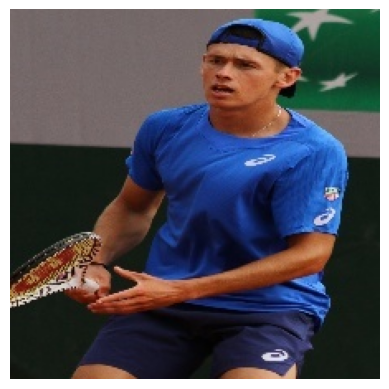

In [ ]:
import matplotlib.pyplot as plt

image_path = f"{path}/train/tennis/001.jpg"
img = plt.imread(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
train_path = f"{path}/train"
evaluation_path = f"{path}/valid"
test_path = f"{path}/test"

## **Preprocessing and Generate a Dataset**

In [ ]:
image_size = (224, 224)
batch_size = 32

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    train_path,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
)

Found 13492 files belonging to 100 classes.


In [ ]:
evaluation_ds = keras.utils.image_dataset_from_directory(
    evaluation_path,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
)

Found 500 files belonging to 100 classes.


In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    test_path,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
)

Found 500 files belonging to 100 classes.


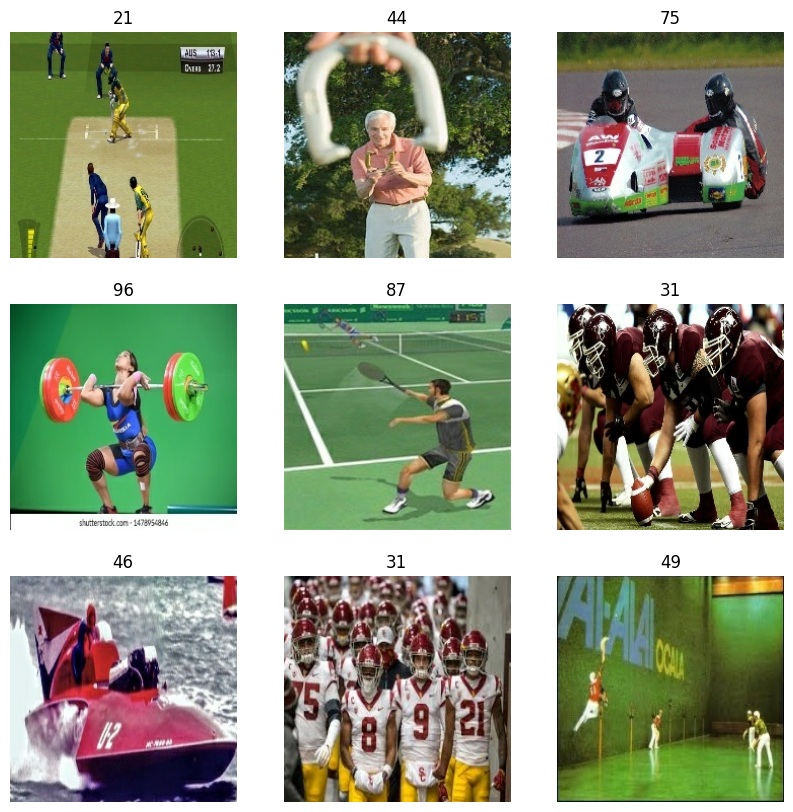

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(5):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(labels[i].numpy().argmax())
        plt.axis("off")

## **Data augmentation**

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

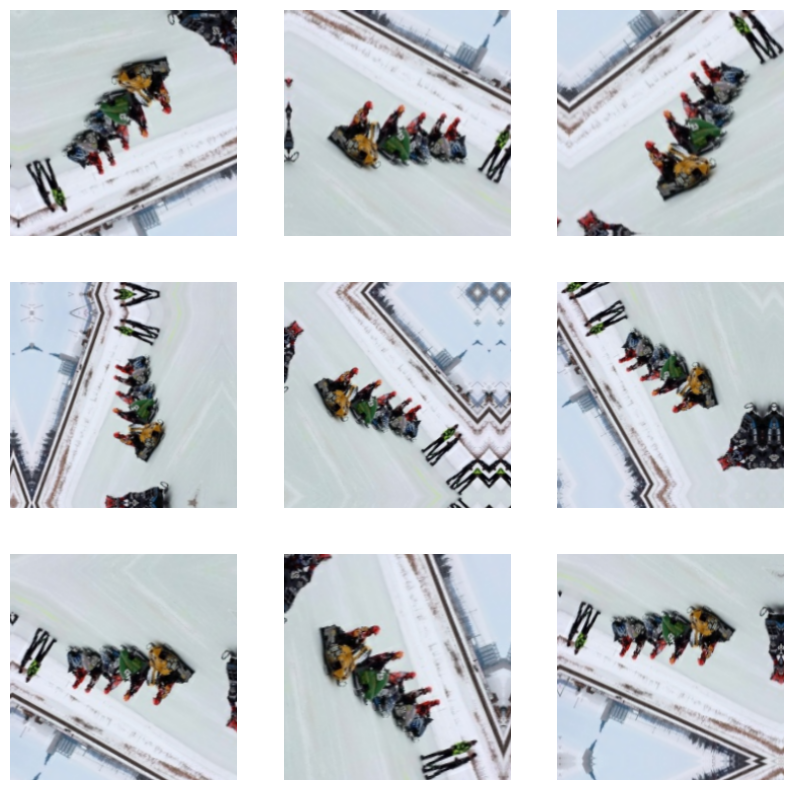

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

## **Build the Model**
- Available Models
https://keras.io/api/applications/

**InceptionResNetV2**
- Size 215 MB
- 80.3%	Top-1 Accuracy
- 95.3% Top-5 Accuracy

In [ ]:
from keras.applications import InceptionResNetV2

image_size = (224, 224)

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
base_model.trainable = True

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import tensorflow as tf

image_size = (224, 224)
num_classes = 100

inputs = tf.keras.Input(shape=(image_size[0], image_size[1], 3))
x = base_model(inputs)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='CategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    39,322,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │       102,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,761,860 (357.67 MB)

 Trainable params: 93,701,316 (357.44 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [ ]:
from keras.callbacks import EarlyStopping

epochs = 50

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0.001,      # Minimum change to be considered an improvement
    patience=5,           # Stop after 5 epochs with no improvement
    mode='min',           # Minimize the validation loss
    restore_best_weights=True # Restore weights from the best epoch
)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    early_stopping,
]

# Apply data augmentation to the training dataset
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

history = model.fit(
    augmented_train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=evaluation_ds,
)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 291s 326ms/step - accuracy: 0.1088 - loss: 4.1264 - val_accuracy: 0.3880 - val_loss: 2.4711
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 53s 124ms/step - accuracy: 0.3605 - loss: 2.5523 - val_accuracy: 0.5720 - val_loss: 1.3715
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 54s 126ms/step - accuracy: 0.5240 - loss: 1.7736 - val_accuracy: 0.7000 - val_loss: 0.9445
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 53s 125ms/step - accuracy: 0.6113 - loss: 1.4050 - val_accuracy: 0.7840 - val_loss: 0.7474
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 53s 124ms/step - accuracy: 0.6626 - loss: 1.1817 - val_accuracy: 0.7800 - val_loss: 0.6825
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 53s 124ms/step - accuracy: 0.7198 - loss: 0.9792 - val_accuracy: 0.8180 - val_loss: 0.6045
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 53s 123ms/step - accuracy: 0.7507 - loss: 0.8637 - val_accuracy: 0.8280 - val_loss: 0.5219
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 53s 124ms/step - accuracy: 0.7731 - loss: 

## **Predict**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


np.int64(36)

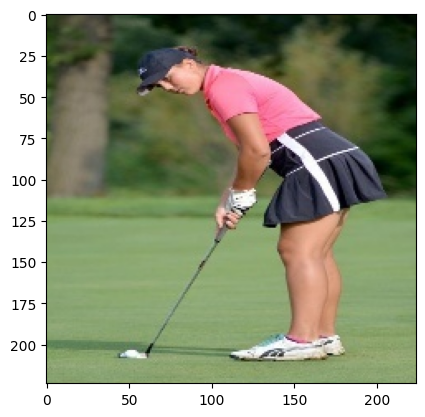

In [ ]:
img = keras.utils.load_img(f"{path}/test/golf/5.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

predictions = model.predict(img_array)
sport = predictions[0].argmax()
sport

### **Evaluation of Model**

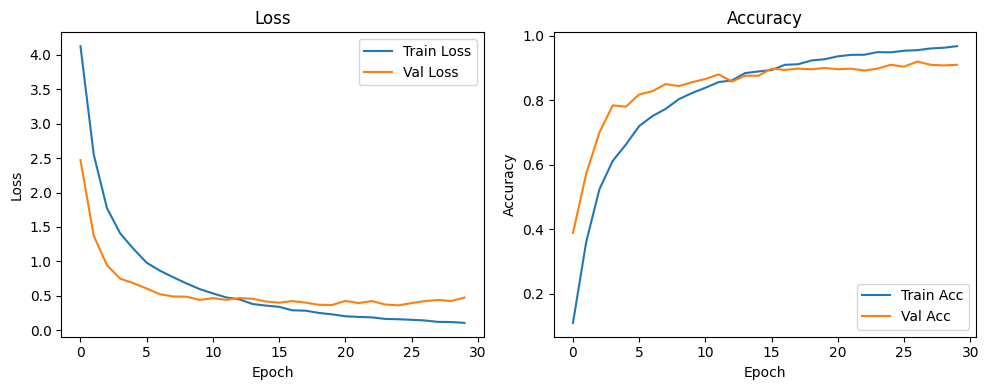

In [ ]:
import matplotlib.pyplot as plt

# Get values
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy') or history.history.get('val_acc')

# Plot Loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(np.argmax(labels, axis=1))
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:")
print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Test Accuracy: 0.942
Classification Report:
              precision    recall  f1-score   support

           0       0.45      1.00      0.62         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


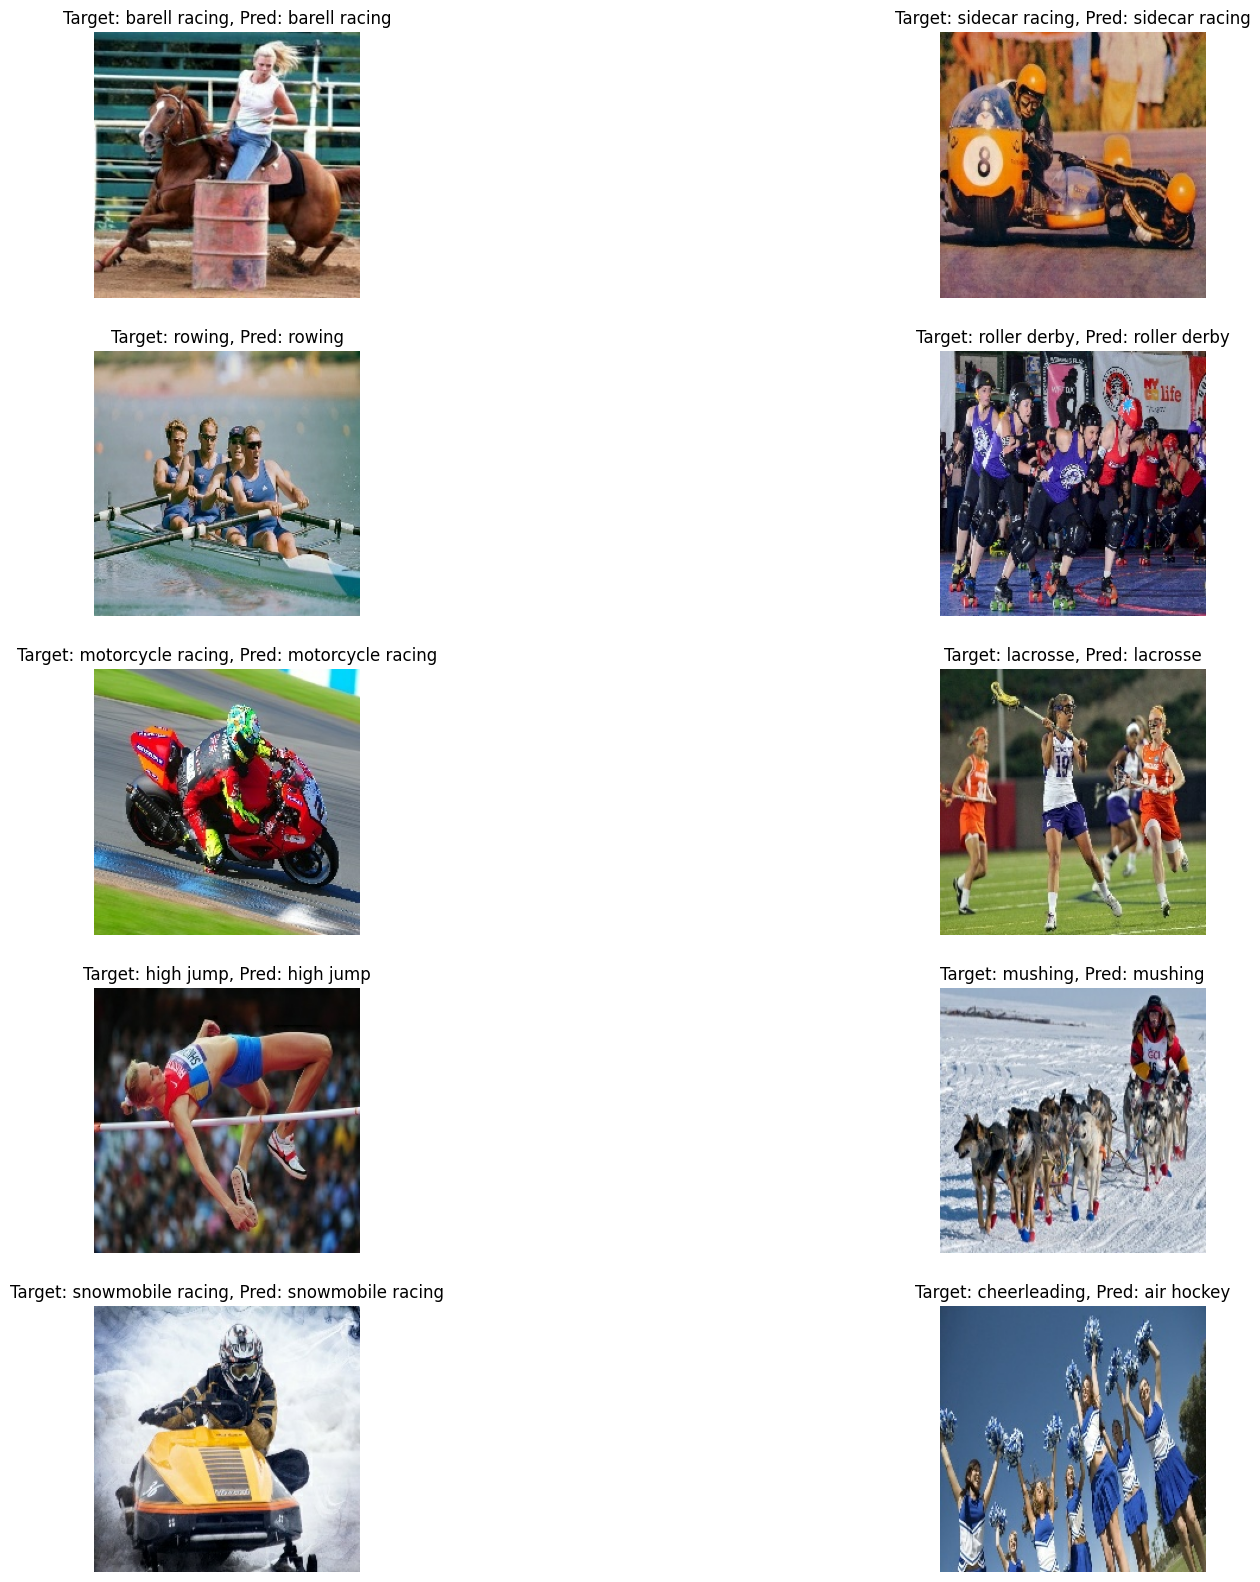

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_samples(images, true_labels, pred_labels, class_names, sample_count=10):
    plt.figure(figsize=(20, 20))
    for i in range(sample_count):
        plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].astype("uint8")) # Removed .numpy()
        true_label_name = class_names[true_labels[i]]
        pred_label_name = class_names[pred_labels[i]]
        plt.title(f"Target: {true_label_name}, Pred: {pred_label_name}")
        plt.axis('off')
    plt.show()

# Get class names from the test dataset
class_names = test_ds.class_names

# Collect images, true labels, and predicted labels from the test dataset
all_images = []
all_true_labels = []
all_pred_labels = []

for images, labels in test_ds:
    all_images.extend(images)
    all_true_labels.extend(np.argmax(labels, axis=1))
    predictions = model.predict(images)
    all_pred_labels.extend(np.argmax(predictions, axis=1))

all_images = np.array(all_images)
all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)

# Display sample predictions
display_samples(all_images, all_true_labels, all_pred_labels, class_names, sample_count=10)

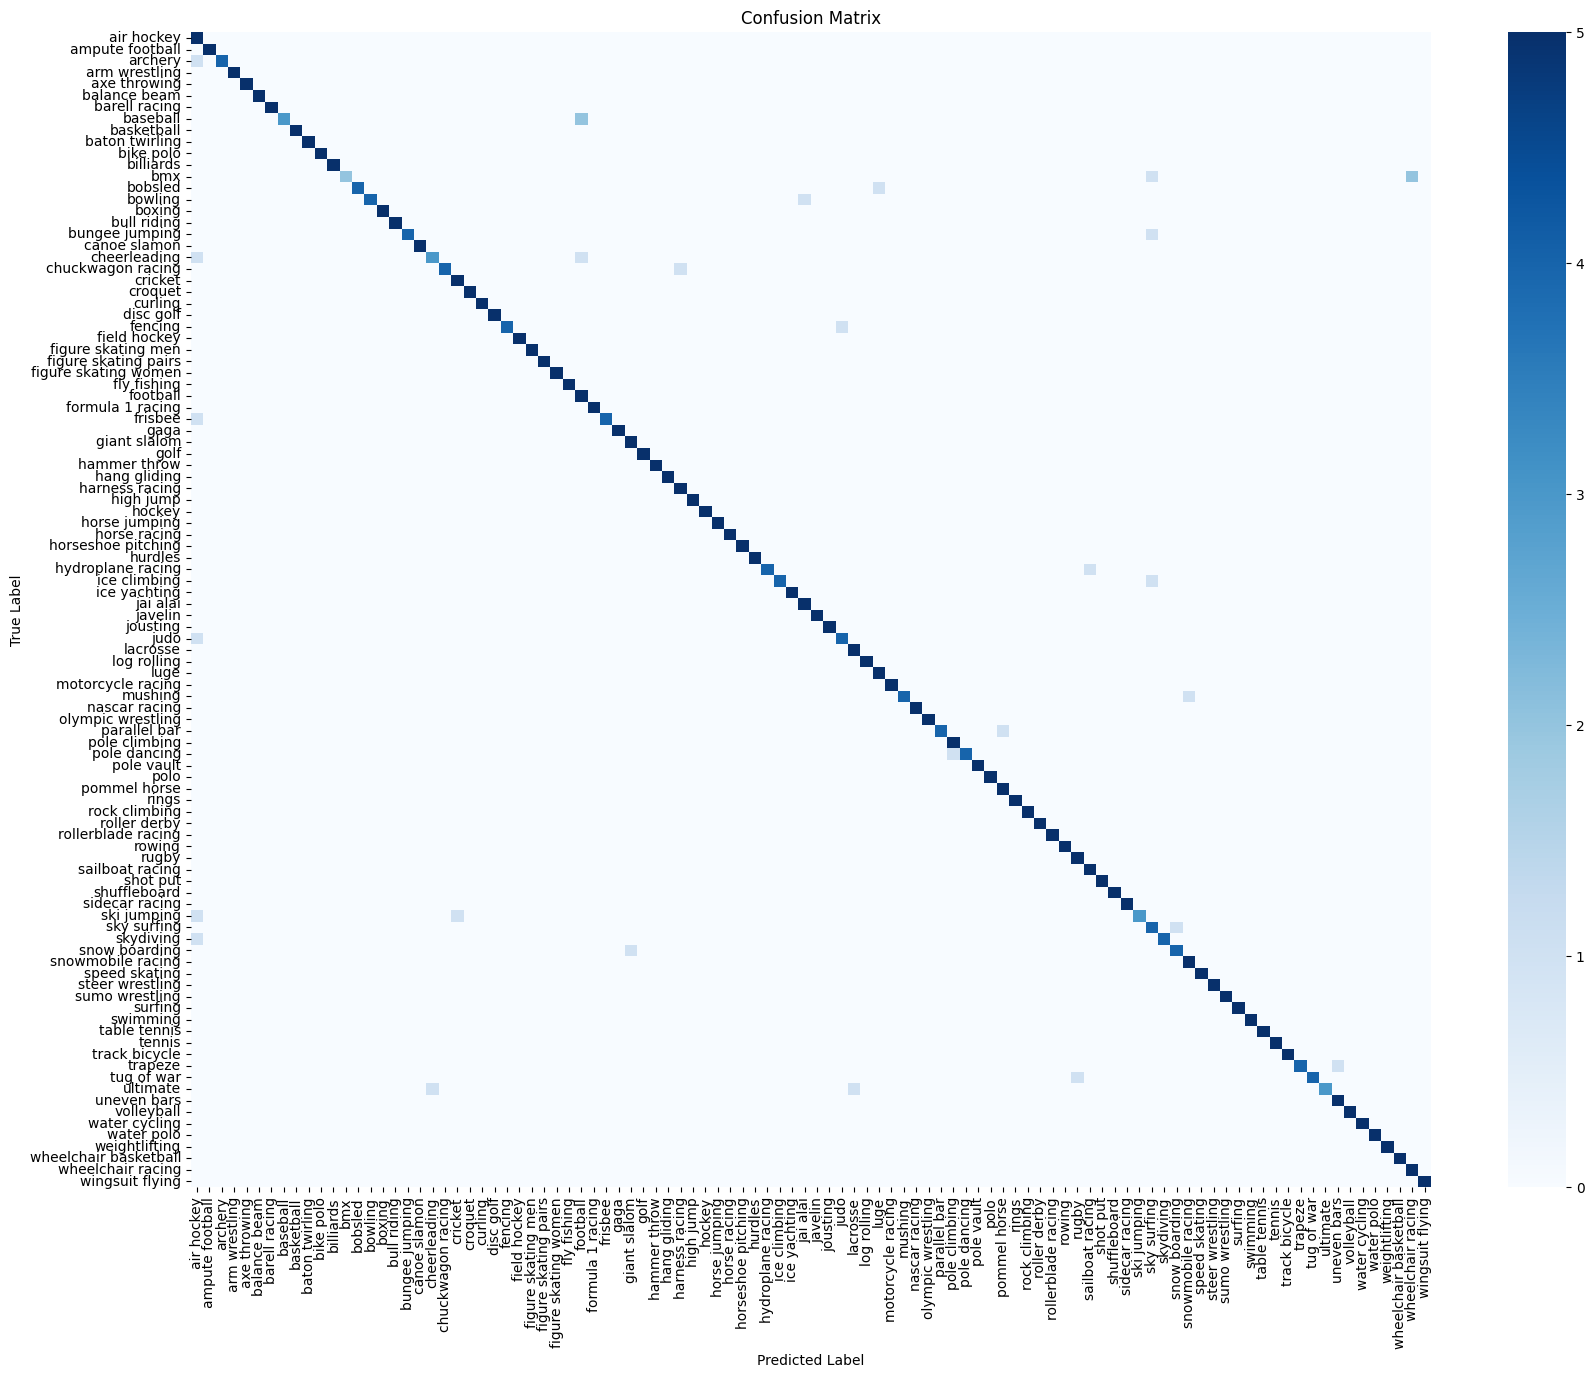

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names
class_names = test_ds.class_names

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('model-sports-image-classification-transfer.keras')

## **Grad-CAM class activation visualization**
The Grad-CAM algorithm is a technique that produces a visual "heatmap" to show what parts of an image a Convolutional Neural Network (CNN) is focusing on to make a decision. It's an interpretability tool that helps us understand the "why" behind a prediction.

In essence, Grad-CAM (Gradient-weighted Class Activation Mapping) allows you to see which regions of an input image were most important for the model to classify it with a specific label

The Grad-CAM algorithm

References:
- https://keras.io/examples/vision/grad_cam/
- https://www.pinecone.io/learn/class-activation-maps/

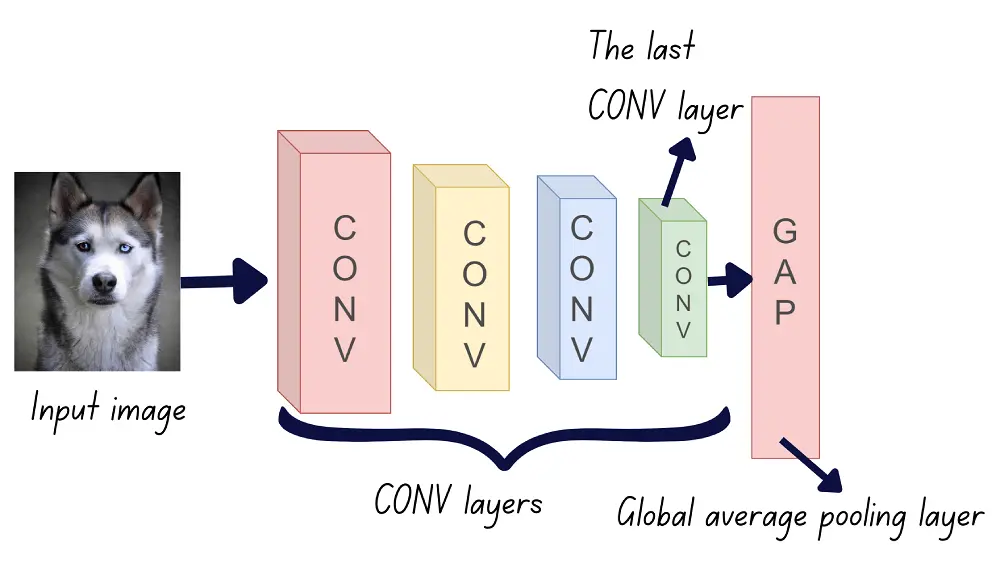

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
import numpy as np
import tensorflow as tf

def make_gradcam_heatmap(img_array, backbone, class_index):
    last_conv_layer = backbone.get_layer("conv_7b").output
    grad_model = tf.keras.Model(inputs=backbone.input, outputs=last_conv_layer)

    with tf.GradientTape() as tape:
        conv_outputs = grad_model(img_array)
        tape.watch(conv_outputs)
        class_score = tf.reduce_mean(conv_outputs[..., :])

    grads = tape.gradient(class_score, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


In [ ]:
import cv2
import matplotlib.pyplot as plt

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img.astype(np.uint8), 1-alpha, heatmap, alpha, 0)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

Processing image 1: Target: barell racing, Predicted: barell racing


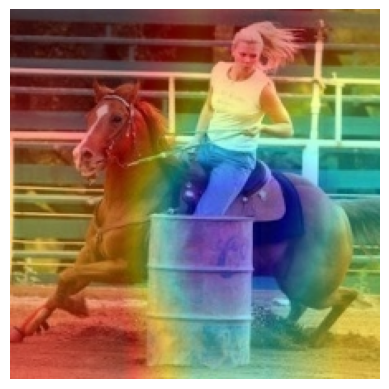

Processing image 2: Target: sidecar racing, Predicted: sidecar racing


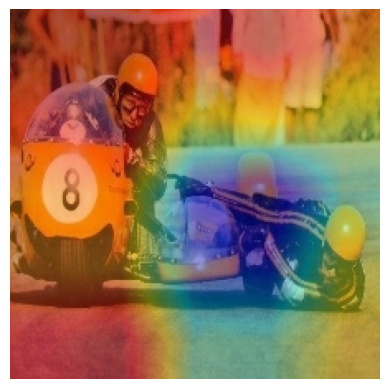

Processing image 3: Target: rowing, Predicted: rowing


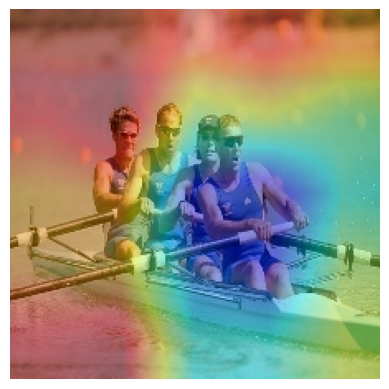

Processing image 4: Target: roller derby, Predicted: roller derby


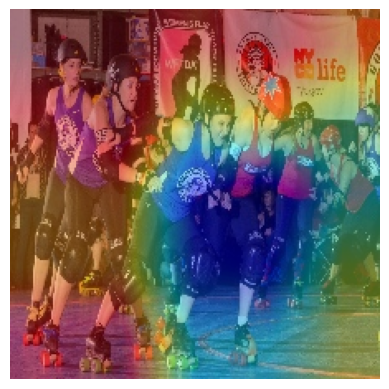

Processing image 5: Target: motorcycle racing, Predicted: motorcycle racing


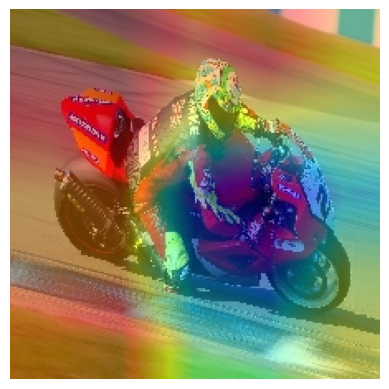

Processing image 6: Target: lacrosse, Predicted: lacrosse


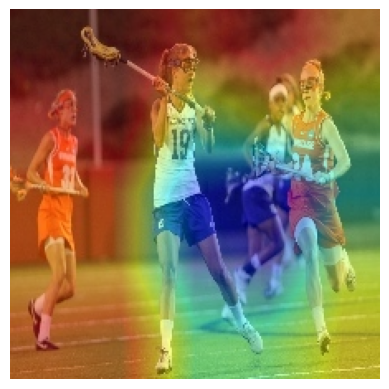

Processing image 7: Target: high jump, Predicted: high jump


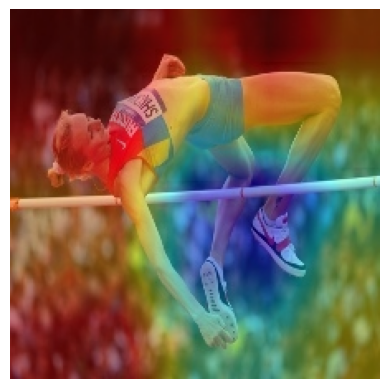

Processing image 8: Target: mushing, Predicted: mushing


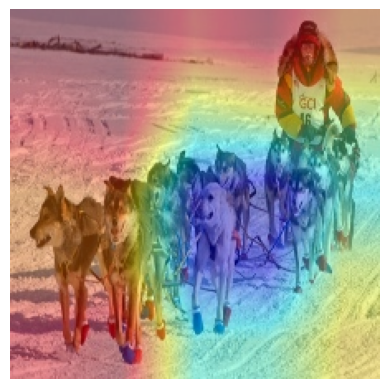

Processing image 9: Target: snowmobile racing, Predicted: snowmobile racing


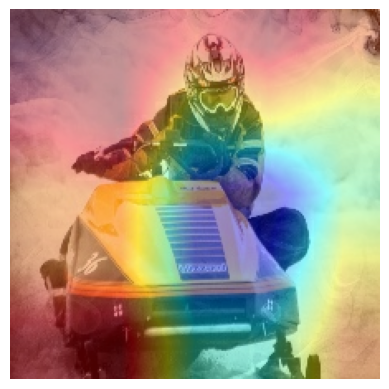

Processing image 10: Target: cheerleading, Predicted: air hockey


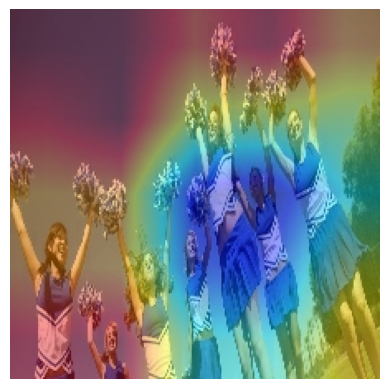

In [ ]:
for i in range(len(all_images[:10])):
    img = all_images[i]
    img_array = np.expand_dims(img / 255.0, axis=0)  # normalizar y agregar batch

    true_label = class_names[all_true_labels[i]]
    pred_label = class_names[all_pred_labels[i]]

    print(f"Processing image {i+1}: Target: {true_label}, Predicted: {pred_label}")

    class_index = all_pred_labels[i]

    # Grad-CAM over backbone
    heatmap = make_gradcam_heatmap(img_array, base_model, class_index)

    display_gradcam(img, heatmap)
